In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import skimage
import math
import time
from math import log10, sqrt 

print("numpy version : {}".format(np.__version__))
print("tensorflow version : {}".format(tf.__version__))

numpy version : 1.19.5
tensorflow version : 2.5.0


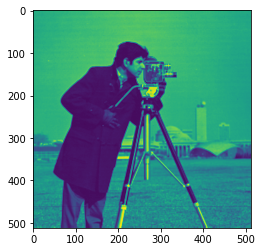

In [2]:
Image = skimage.data.camera()
Image = Image.astype(np.float32)
Image = Image / 255

plt.imshow(Image)

In [3]:
def make_coordiante(shape):
    x_coordinates = np.linspace(-1, +1, shape[0])
    y_coordinates = np.linspace(-1, +1, shape[1])
    x_coordinates, y_coordinates = np.meshgrid(x_coordinates, y_coordinates)
    x_coordinates = x_coordinates.flatten()
    y_coordinates = y_coordinates.flatten()
    Coordinates = np.stack([x_coordinates, y_coordinates]).T
    return Coordinates

In [4]:
Coordinates = make_coordiante(Image.shape)
RGB_values = Image.flatten()

In [5]:
Coordinates.shape

(262144, 2)

In [150]:
tf.math.imag(tf.math.exp(1j * 10) + tf.math.exp(1j * 5))

<tf.Tensor: shape=(), dtype=float64, numpy=-1.5029453855525081>

In [8]:
import numpy as np
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import constraints
from tensorflow.keras import regularizers
from tensorflow.keras import initializers
from tensorflow.keras.layers import InputSpec


'COMPLEX DENSE'
class complex_Dense(tf.keras.layers.Layer):
    """
    tf.keras.layers.Dense(
        units, activation=None, use_bias=True, kernel_initializer='glorot_uniform',
        bias_initializer='zeros', kernel_regularizer=None, bias_regularizer=None,
        activity_regularizer=None, kernel_constraint=None, bias_constraint=None,
        **kwargs
    )
    """
    def __init__ (self, units = 512,
                        activation = None,
                        use_bias   = True, 
                        kernel_initializer = 'glorot_uniform',
                        bias_initializer   = 'zeros', 
                        kernel_regularizer = None, 
                        bias_regularizer   = None,
                        activity_regularizer = None, 
                        kernel_constraint    = None, 
                        bias_constraint      = None):
        super(complex_Dense, self).__init__()
        self.units                = units
        self.activation           = activation
        self.use_bias             = use_bias
        self.kernel_initializer   = kernel_initializer
        self.bias_initializer     = bias_initializer
        self.kernel_regularizer   = kernel_regularizer
        self.bias_regularizer     = bias_regularizer
        self.activity_regularizer = activity_regularizer
        self.kernel_constraint    = kernel_constraint
        self.bias_constraint      = bias_constraint
        
        
    def build (self, inputs_shape):
        self.real_Dense = tf.keras.layers.Dense(units = self.units, 
                                                activation = self.activation, 
                                                use_bias   = self.use_bias, 
                                                kernel_initializer = self.kernel_initializer,
                                                bias_initializer   = self.bias_initializer, 
                                                kernel_regularizer = self.kernel_regularizer,
                                                bias_regularizer   = self.bias_regularizer,
                                                activity_regularizer = self.activity_regularizer, 
                                                kernel_constraint    = self.kernel_constraint,
                                                bias_constraint      = self.bias_constraint)
        
        self.imag_Dense = tf.keras.layers.Dense(units = self.units, 
                                                activation = self.activation, 
                                                use_bias   = self.use_bias, 
                                                kernel_initializer = self.kernel_initializer,
                                                bias_initializer   = self.bias_initializer, 
                                                kernel_regularizer = self.kernel_regularizer,
                                                bias_regularizer   = self.bias_regularizer,
                                                activity_regularizer = self.activity_regularizer, 
                                                kernel_constraint    = self.kernel_constraint,
                                                bias_constraint      = self.bias_constraint)
        
        super(complex_Dense, self).build(inputs_shape)
        

    def call (self, real_inputs, imag_inputs):
        real_outputs = self.real_Dense(real_inputs) - self.imag_Dense(imag_inputs)
        imag_outputs = self.imag_Dense(real_inputs) + self.real_Dense(imag_inputs)

        return real_outputs, imag_outputs

In [9]:
import numpy as np
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import constraints
from tensorflow.keras import regularizers
from tensorflow.keras import initializers
from tensorflow.keras.layers import InputSpec


'COMPLEX SIN DENSE'
class SinComplexDense(tf.keras.layers.Layer):

    def __init__ (self, in_features,
                        units,
                        use_activation=True,
                        bias=True,
                        is_first=False,
                        omega_0=30.):
        super(SinComplexDense, self).__init__()
        self.in_features = in_features
        self.units = units
        self.bias = bias
        self.use_activation = use_activation
        self.is_first = is_first
        self.omega_0 = omega_0
        
    
    def cal_limit(self):
        X = 2 * np.random.rand(1000, self.in_features) - 1
        W = 2 * np.random.rand(self.in_features, self.units) - 1
        A = np.matmul(X, W)
        return np.std(A)
    
    def init_weights(self):
        if self.is_first:
            return tf.keras.initializers.RandomUniform(minval=-1 / (self.cal_limit()),
                                                       maxval= 1 / (self.cal_limit()))
        else:
            return tf.keras.initializers.RandomUniform(minval=-np.sqrt(6. / self.in_features) / self.omega_0,
                                                       maxval= np.sqrt(6. / self.in_features) / self.omega_0)

    def build (self, inputs_shape):
        self.real_Dense = tf.keras.layers.Dense(self.units,
                                                use_bias=self.bias,
                                                kernel_initializer=self.init_weights(),
                                                input_shape=(self.in_features,))
        
        self.imag_Dense = tf.keras.layers.Dense(self.units,
                                                use_bias=self.bias,
                                                kernel_initializer=self.init_weights(),
                                                input_shape=(self.in_features,))
        
        super(SinComplexDense, self).build(inputs_shape)
        

    def call (self, real_inputs, imag_inputs):
        real_outputs = self.real_Dense(real_inputs) - self.imag_Dense(imag_inputs)
        imag_outputs = self.imag_Dense(real_inputs) + self.real_Dense(imag_inputs)
        if self.use_activation:
           return tf.cos(self.omega_0 * real_outputs), tf.sin(self.omega_0 * imag_outputs)
        else:
           return real_outputs, imag_outputs

In [159]:
import numpy as np
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import constraints
from tensorflow.keras import regularizers
from tensorflow.keras import initializers
from tensorflow.keras.layers import InputSpec


'COMPLEX SIN DENSE WITH COMPLEX ACTIVATION(  exp(jwx)  )'
class SinComplexDense(tf.keras.layers.Layer):

    def __init__ (self, in_features,
                        units,
                        use_activation=True,
                        bias=True,
                        is_first=False,
                        omega_0=30.):
        super(SinComplexDense, self).__init__()
        self.in_features = in_features
        self.units = units
        self.bias = bias
        self.use_activation = use_activation
        self.is_first = is_first
        self.omega_0 = omega_0
        
    
    def cal_limit(self):
        X = 2 * np.random.rand(1000, self.in_features) - 1
        W = 2 * np.random.rand(self.in_features, self.units) - 1
        A = np.matmul(X, W)
        return np.std(A)
    
    def init_weights(self):
        if self.is_first:
            return tf.keras.initializers.RandomUniform(minval=-1 / (self.cal_limit()),
                                                       maxval= 1 / (self.cal_limit()))
        else:
            return tf.keras.initializers.RandomUniform(minval=-np.sqrt(6. / self.in_features) / self.omega_0,
                                                       maxval= np.sqrt(6. / self.in_features) / self.omega_0)

    def build (self, inputs_shape):
        self.real_Dense = tf.keras.layers.Dense(self.units,
                                                use_bias=self.bias,
                                                kernel_initializer=self.init_weights(),
                                                input_shape=(self.in_features,))
        
        self.imag_Dense = tf.keras.layers.Dense(self.units,
                                                use_bias=self.bias,
                                                kernel_initializer=self.init_weights(),
                                                input_shape=(self.in_features,))
        
        super(SinComplexDense, self).build(inputs_shape)
        

    def call (self, real_inputs, imag_inputs):
        real_outputs = self.real_Dense(real_inputs) - self.imag_Dense(imag_inputs)
        imag_outputs = self.imag_Dense(real_inputs) + self.real_Dense(imag_inputs)
        if self.use_activation:
           return tf.cos(self.omega_0 * real_outputs) - tf.sin(self.omega_0 * imag_outputs), \
                  tf.sin(self.omega_0 * real_outputs) + tf.cos(self.omega_0 * imag_outputs)
        else:
           return real_outputs, imag_outputs

In [47]:
import numpy as np
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import constraints
from tensorflow.keras import regularizers
from tensorflow.keras import initializers
from tensorflow.keras.layers import InputSpec


'COMPLEX SIN DENSE WITH SPECIFIC INITIALIZATION'
class SinComplexDense(tf.keras.layers.Layer):

    def __init__ (self, in_features,
                        units,
                        use_activation=True,
                        bias=True,
                        is_first=False,
                        omega_0=30.):
        super(SinComplexDense, self).__init__()
        self.in_features = in_features
        self.units = units
        self.bias = bias
        self.use_activation = use_activation
        self.is_first = is_first
        self.omega_0 = omega_0
        
    
    
    def init_weights(self):
        if self.is_first:
            return tf.keras.initializers.RandomUniform(minval=-1 / self.in_features,
                                                       maxval= 1 / self.in_features)
        else:
            return tf.keras.initializers.RandomUniform(minval=-np.sqrt(6. / self.in_features) / self.omega_0,
                                                       maxval= np.sqrt(6. / self.in_features) / self.omega_0)

    def build (self, inputs_shape):
        self.real_Dense = tf.keras.layers.Dense(self.units,
                                                use_bias=self.bias,
                                                kernel_initializer=self.init_weights(),
                                                input_shape=(self.in_features,))
        
        self.imag_Dense = tf.keras.layers.Dense(self.units,
                                                use_bias=self.bias,
                                                kernel_initializer=self.init_weights(),
                                                input_shape=(self.in_features,))
        
        super(SinComplexDense, self).build(inputs_shape)
        

    def call (self, real_inputs, imag_inputs):
        real_outputs = self.real_Dense(real_inputs) - self.imag_Dense(imag_inputs)
        imag_outputs = self.imag_Dense(real_inputs) + self.real_Dense(imag_inputs)
        if self.use_activation:
           return tf.cos(self.omega_0 * real_outputs), tf.sin(self.omega_0 * imag_outputs)
        else:
           return real_outputs, imag_outputs

In [99]:
import numpy as np
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import constraints
from tensorflow.keras import regularizers
from tensorflow.keras import initializers
from tensorflow.keras.layers import InputSpec


'COMPLEX PARAMETRIC DENSE WITH SPECIFIC INITIALIZATION'
class ParaSinComplexDense(tf.keras.layers.Layer):

    def __init__ (self, in_features,
                        units,
                        use_activation=True,
                        bias=True,
                        is_first=False,
                        omega_0=30.):
        super(ParaSinComplexDense, self).__init__()
        self.in_features = in_features
        self.units = units
        self.bias = bias
        self.use_activation = use_activation
        self.is_first = is_first
        self.omega_0 = omega_0
        
    
    def cal_limit(self):
        X = 2 * np.random.rand(1000, self.in_features) - 1
        W = 2 * np.random.rand(self.in_features, self.units) - 1
        A = np.matmul(X, W)
        return np.std(A)
    
    def init_weights(self):
        if self.is_first:
            return tf.keras.initializers.RandomUniform(minval=-1 / (self.cal_limit()),
                                                       maxval= 1 / (self.cal_limit()))
        else:
            return tf.keras.initializers.RandomUniform(minval=-np.sqrt(6. / self.in_features) / self.omega_0,
                                                       maxval= np.sqrt(6. / self.in_features) / self.omega_0)

    def build (self, inputs_shape):
        self.real_Dense = tf.keras.layers.Dense(self.units,
                                                use_bias=self.bias,
                                                kernel_initializer=self.init_weights(),
                                                input_shape=(self.in_features,))
        
        self.imag_Dense = tf.keras.layers.Dense(self.units,
                                                use_bias=self.bias,
                                                kernel_initializer=self.init_weights(),
                                                input_shape=(self.in_features,))
        

        if self.use_activation:

            self.a_1 = self.add_weight(
                name='a_1',
                shape=(1,),
                initializer='zeros',
                trainable=True)


            self.a0 = self.add_weight(
                name='a0',
                shape=(1,),
                initializer='ones',
                trainable=True)
            self.w0 = self.add_weight(
                name='w0',
                shape=(1,),
                initializer='ones',
                trainable=True)
            self.shift0 = self.add_weight(
                name='shift0',
                shape=(1,),
                initializer='zeros',
                trainable=True)

            self.a1 = self.add_weight(
                name='a1',
                shape=(1,),
                initializer='ones',
                trainable=True)
            self.w1 = self.add_weight(
                name='w1',
                shape=(1,),
                initializer='ones',
                trainable=True)
            self.shift1 = self.add_weight(
                name='shift1',
                shape=(1,),
                initializer='zeros',
                trainable=True)
            


            self.a2 = self.add_weight(
                name='a2',
                shape=(1,),
                initializer=tf.keras.initializers.constant(1/20.),
                trainable=True)
            self.w2 = self.add_weight(
                name='w2',
                shape=(1,),
                initializer=tf.keras.initializers.constant(2.),
                trainable=True)
            self.shift2 = self.add_weight(
                name='shift2',
                shape=(1,),
                initializer='zeros',
                trainable=True)

            self.a3 = self.add_weight(
                name='a3',
                shape=(1,),
                initializer=tf.keras.initializers.constant(0.),
                trainable=True)
            self.w3 = self.add_weight(
                name='w3',
                shape=(1,),
                initializer=tf.keras.initializers.constant(2.),
                trainable=True)
            self.shift3 = self.add_weight(
                name='shift3',
                shape=(1,),
                initializer='zeros',
                trainable=True)
            


            self.a4 = self.add_weight(
                name='a4',
                shape=(1,),
                initializer=tf.keras.initializers.constant(0.),
                trainable=True)
            self.w4 = self.add_weight(
                name='w4',
                shape=(1,),
                initializer=tf.keras.initializers.constant(3.),
                trainable=True)
            self.shift4 = self.add_weight(
                name='shift4',
                shape=(1,),
                initializer='zeros',
                trainable=True)

            self.a5 = self.add_weight(
                name='a5',
                shape=(1,),
                initializer=tf.keras.initializers.constant(1/30.),
                trainable=True)
            self.w5 = self.add_weight(
                name='w5',
                shape=(1,),
                initializer=tf.keras.initializers.constant(3.),
                trainable=True)
            self.shift5 = self.add_weight(
                name='shift5',
                shape=(1,),
                initializer='zeros',
                trainable=True)
            
        super(ParaSinComplexDense, self).build(inputs_shape)

    def call (self, real_inputs, imag_inputs):
        real_outputs = self.real_Dense(real_inputs) - self.imag_Dense(imag_inputs)
        imag_outputs = self.imag_Dense(real_inputs) + self.real_Dense(imag_inputs)
        if self.use_activation:
           real_outputs =  self.a_1 * self.omega_0 * real_outputs + \
                           self.a1 * tf.cos(self.w1 * self.omega_0 * real_outputs + self.shift1) + \
                           self.a3 * tf.cos(self.w3 * self.omega_0 * real_outputs + self.shift3) + \
                           self.a5 * tf.cos(self.w5 * self.omega_0 * real_outputs + self.shift5)

           imag_outputs =  self.a0 * tf.sin(self.w0 * self.omega_0 * imag_outputs + self.shift0) + \
                           self.a2 * tf.sin(self.w2 * self.omega_0 * imag_outputs + self.shift2) + \
                           self.a4 * tf.sin(self.w4 * self.omega_0 * imag_outputs + self.shift4)
           return real_outputs, imag_outputs
        else:
           return real_outputs, imag_outputs

In [174]:
import numpy as np
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import initializers
from tensorflow.keras.layers import InputSpec


'REAL PARAMETRIC DENSE WITH SPECIFIC INITIALIZATION'
class ParaSineLayer(tf.keras.layers.Layer):

    def __init__ (self, in_features,
                        units,
                        use_activation=True,
                        bias=True,
                        is_first=False,
                        omega_0=30.):
        super(ParaSineLayer, self).__init__()
        self.in_features = in_features
        self.units = units
        self.bias = bias
        self.use_activation = use_activation
        self.is_first = is_first
        self.omega_0 = omega_0
        
    
    def cal_limit(self):
        X = 2 * np.random.rand(1000, self.in_features) - 1
        W = 2 * np.random.rand(self.in_features, self.units) - 1
        A = np.matmul(X, W)
        return np.std(A)
    
    def init_weights(self):
        if self.is_first:
            return tf.keras.initializers.RandomUniform(minval=-1 / (self.cal_limit()),
                                                       maxval= 1 / (self.cal_limit()))
        else:
            return tf.keras.initializers.RandomUniform(minval=-np.sqrt(6. / self.in_features) / self.omega_0,
                                                       maxval= np.sqrt(6. / self.in_features) / self.omega_0)

    def build (self, inputs_shape):

        self.dense = tf.keras.layers.Dense(self.units,
                                    use_bias=self.bias,
                                    kernel_initializer=self.init_weights(),
                                    input_shape=(self.in_features,))
        
        if self.use_activation:

            self.a_1 = self.add_weight(
                name='a_1',
                shape=(1,),
                initializer='zeros',
                trainable=True)


            self.a0 = self.add_weight(
                name='a0',
                shape=(1,),
                initializer='ones',
                trainable=True)
            self.w0 = self.add_weight(
                name='w0',
                shape=(1,),
                initializer='ones',
                trainable=True)
            self.shift0 = self.add_weight(
                name='shift0',
                shape=(1,),
                initializer='zeros',
                trainable=True)

            self.a1 = self.add_weight(
                name='a1',
                shape=(1,),
                initializer='ones',
                trainable=True)
            self.w1 = self.add_weight(
                name='w1',
                shape=(1,),
                initializer='ones',
                trainable=True)
            self.shift1 = self.add_weight(
                name='shift1',
                shape=(1,),
                initializer='zeros',
                trainable=True)
            


            self.a2 = self.add_weight(
                name='a2',
                shape=(1,),
                initializer=tf.keras.initializers.constant(1/20.),
                trainable=True)
            self.w2 = self.add_weight(
                name='w2',
                shape=(1,),
                initializer=tf.keras.initializers.constant(2.),
                trainable=True)
            self.shift2 = self.add_weight(
                name='shift2',
                shape=(1,),
                initializer='zeros',
                trainable=True)

            self.a3 = self.add_weight(
                name='a3',
                shape=(1,),
                initializer=tf.keras.initializers.constant(0.),
                trainable=True)
            self.w3 = self.add_weight(
                name='w3',
                shape=(1,),
                initializer=tf.keras.initializers.constant(2.),
                trainable=True)
            self.shift3 = self.add_weight(
                name='shift3',
                shape=(1,),
                initializer='zeros',
                trainable=True)
            


            self.a4 = self.add_weight(
                name='a4',
                shape=(1,),
                initializer=tf.keras.initializers.constant(0.),
                trainable=True)
            self.w4 = self.add_weight(
                name='w4',
                shape=(1,),
                initializer=tf.keras.initializers.constant(3.),
                trainable=True)
            self.shift4 = self.add_weight(
                name='shift4',
                shape=(1,),
                initializer='zeros',
                trainable=True)

            self.a5 = self.add_weight(
                name='a5',
                shape=(1,),
                initializer=tf.keras.initializers.constant(1/30.),
                trainable=True)
            self.w5 = self.add_weight(
                name='w5',
                shape=(1,),
                initializer=tf.keras.initializers.constant(3.),
                trainable=True)
            self.shift5 = self.add_weight(
                name='shift5',
                shape=(1,),
                initializer='zeros',
                trainable=True)
            
        super(ParaSineLayer, self).build(inputs_shape)

    def call (self, input_tensor):
        befor_activation = self.dense(input_tensor)
        if self.use_activation:
           after_activation = self.a_1 * self.omega_0 * befor_activation + \
                              self.a0 * tf.sin(self.w0 * self.omega_0 * befor_activation + self.shift0) + \
                              self.a1 * tf.cos(self.w1 * self.omega_0 * befor_activation + self.shift1) + \
                              self.a2 * tf.sin(self.w2 * self.omega_0 * befor_activation + self.shift2) + \
                              self.a3 * tf.cos(self.w3 * self.omega_0 * befor_activation + self.shift3) + \
                              self.a4 * tf.sin(self.w4 * self.omega_0 * befor_activation + self.shift4) + \
                              self.a5 * tf.cos(self.w5 * self.omega_0 * befor_activation + self.shift5)
           return after_activation
        else:
           return befor_activation

In [175]:
import numpy as np
import tensorflow as tf



def complex_flatten (real, imag):
    
    real = tf.keras.layers.Flatten()(real)
    imag = tf.keras.layers.Flatten()(imag)
    
    return real, imag


def CReLU (real, imag):
    
    real = tf.keras.layers.ReLU()(real)
    imag = tf.keras.layers.ReLU()(imag)
    
    return real, imag


def zReLU (real, imag):

    real = tf.keras.layers.ReLU()(real)
    imag = tf.keras.layers.ReLU()(imag)
    
    real_flag = tf.cast(tf.cast(real, tf.bool), tf.float32)
    imag_flag = tf.cast(tf.cast(imag, tf.bool), tf.float32)
    
    flag = real_flag * imag_flag

    real = tf.math.multiply(real, flag)
    imag = tf.math.multiply(imag, flag)

    return real, imag


def modReLU (real, imag):
    
    norm = tf.abs(tf.complex(real, imag))
    bias = tf.Variable(np.zeros([norm.get_shape()[-1]]), trainable = True, dtype=tf.float32)
    relu = tf.nn.relu(norm + bias)
    
    real = tf.math.multiply(relu / norm + (1e+5), real)
    imag = tf.math.multiply(relu / norm + (1e+5), imag)
    
    return real, imag


def CLeaky_ReLU (real, imag):

    real = tf.nn.leaky_relu(real)
    imag = tf.nn.leaky_relu(imag)

    return real, imag


def complex_tanh (real, imag):

    real = tf.nn.tanh(real)
    imag = tf.nn.tanh(imag)

    return real, imag


def complex_softmax (real, imag):
    
    magnitude = tf.abs(tf.complex(real, imag))
    magnitude = tf.keras.layers.Softmax()(magnitude)
    
    return magnitude


def magnitude_function (real, imag):
    
    magnitude = tf.abs(tf.complex(real, imag))
    
    return magnitude

In [188]:
tf.keras.backend.clear_session()
hidden_units = 365

In [162]:
# Complex Relu

real = tf.keras.Input(shape = (1,))
imag = tf.keras.Input(shape = (1,))


x_r, x_i = SinComplexDense(in_features=1, units=hidden_units, bias=True, use_activation=False, is_first=True)(real, imag)
x_r, x_i = CReLU(30 * x_r, 30 * x_i)
x_r, x_i = SinComplexDense(in_features=hidden_units, units=hidden_units, bias=True, use_activation=False, is_first=False)(x_r, x_i)
x_r, x_i = CReLU(30 * x_r, 30 * x_i)
x_r, x_i = SinComplexDense(in_features=hidden_units, units=hidden_units, bias=True, use_activation=False, is_first=False)(x_r, x_i)
x_r, x_i = CReLU(30 * x_r, 30 * x_i)
x_r, x_i = SinComplexDense(in_features=hidden_units, units=hidden_units, bias=True, use_activation=False, is_first=False)(x_r, x_i)
x_r, x_i = CReLU(30 * x_r, 30 * x_i)

x_r, x_i = SinComplexDense(in_features=hidden_units, units=1, bias=True, use_activation=False, is_first=False)(x_r, x_i)
Y = magnitude_function(x_r, x_i)

model = tf.keras.models.Model([real, imag], Y)

In [164]:
# Complex Sin

real = tf.keras.Input(shape = (1,))
imag = tf.keras.Input(shape = (1,))


x_r, x_i = SinComplexDense(in_features=1, units=hidden_units, bias=True, use_activation=True, is_first=True)(real, imag)
x_r, x_i = SinComplexDense(in_features=hidden_units, units=hidden_units, bias=True, use_activation=True, is_first=False)(x_r, x_i)
x_r, x_i = SinComplexDense(in_features=hidden_units, units=hidden_units, bias=True, use_activation=True, is_first=False)(x_r, x_i)
x_r, x_i = SinComplexDense(in_features=hidden_units, units=hidden_units, bias=True, use_activation=True, is_first=False)(x_r, x_i)

x_r, x_i = SinComplexDense(in_features=hidden_units, units=1, bias=True, use_activation=False, is_first=False)(x_r, x_i)
Y = magnitude_function(x_r, x_i)

model = tf.keras.models.Model([real, imag], Y)

In [102]:
#Complex Parametric

real = tf.keras.Input(shape = (1,))
imag = tf.keras.Input(shape = (1,))


x_r, x_i = ParaSinComplexDense(in_features=1, units=hidden_units, bias=True, use_activation=True, is_first=True)(real, imag)
x_r, x_i = ParaSinComplexDense(in_features=hidden_units, units=hidden_units, bias=True, use_activation=True, is_first=False)(x_r, x_i)
x_r, x_i = ParaSinComplexDense(in_features=hidden_units, units=hidden_units, bias=True, use_activation=True, is_first=False)(x_r, x_i)
x_r, x_i = ParaSinComplexDense(in_features=hidden_units, units=hidden_units, bias=True, use_activation=True, is_first=False)(x_r, x_i)

x_r, x_i = ParaSinComplexDense(in_features=hidden_units, units=1, bias=True, use_activation=False, is_first=False)(x_r, x_i)
Y = magnitude_function(x_r, x_i)

model = tf.keras.models.Model([real, imag], Y)

In [189]:
#Real Parametric

real_input = tf.keras.Input(shape = (2,))

x = ParaSineLayer(in_features=2, units=hidden_units, bias=True, use_activation=True, is_first=True)(real_input)
x = ParaSineLayer(in_features=hidden_units, units=hidden_units, bias=True, use_activation=True, is_first=False)(x)
x = ParaSineLayer(in_features=hidden_units, units=hidden_units, bias=True, use_activation=True, is_first=False)(x)
x = ParaSineLayer(in_features=hidden_units, units=hidden_units, bias=True, use_activation=True, is_first=False)(x)

Y = ParaSineLayer(in_features=hidden_units, units=1, bias=True, use_activation=False, is_first=False)(x)

model = tf.keras.models.Model(real_input, Y)


In [190]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
para_sine_layer (ParaSineLay (None, 365)               1114      
_________________________________________________________________
para_sine_layer_1 (ParaSineL (None, 365)               133609    
_________________________________________________________________
para_sine_layer_2 (ParaSineL (None, 365)               133609    
_________________________________________________________________
para_sine_layer_3 (ParaSineL (None, 365)               133609    
_________________________________________________________________
para_sine_layer_4 (ParaSineL (None, 1)                 366       
Total params: 402,307
Trainable params: 402,307
Non-trainable params: 0
_______________________________________________________

In [166]:
# For Complex Network
batch_size = 16 * 1024

dataset = tf.data.Dataset.from_tensor_slices(((Coordinates[:,0], Coordinates[:,1]), RGB_values))
dataset = dataset.shuffle(len(Coordinates)).batch(batch_size)

In [191]:
# For Real Network
batch_size = 16 * 1024

dataset = tf.data.Dataset.from_tensor_slices((Coordinates, RGB_values))
dataset = dataset.shuffle(len(Coordinates)).batch(batch_size)

In [192]:
def scheduler(epoch, lr):
  if epoch < 10:
    return lr
  else:
    if epoch % 5 == 0:
        lr = lr * tf.math.exp(-0.15)
    return lr
callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [193]:
optimizer = tf.keras.optimizers.Adam(1e-4)
loss = tf.keras.losses.MeanSquaredError() 

model.compile(optimizer=optimizer, loss=loss)

In [194]:
epochs = 100

history = model.fit(dataset, epochs=epochs, callbacks=[callback])

Epoch 1/100
16/16 [==============================] - 5s 111ms/step - loss: 0.0618
Epoch 2/100
16/16 [==============================] - 2s 111ms/step - loss: 0.0065
Epoch 3/100
16/16 [==============================] - 2s 111ms/step - loss: 0.0019
Epoch 4/100
16/16 [==============================] - 2s 111ms/step - loss: 8.7678e-04
Epoch 5/100
16/16 [==============================] - 2s 112ms/step - loss: 5.1658e-04
Epoch 6/100
16/16 [==============================] - 2s 112ms/step - loss: 3.6094e-04
Epoch 7/100
16/16 [==============================] - 2s 112ms/step - loss: 2.8220e-04
Epoch 8/100
16/16 [==============================] - 2s 111ms/step - loss: 2.3324e-04
Epoch 9/100
16/16 [==============================] - 2s 112ms/step - loss: 1.9778e-04
Epoch 10/100
16/16 [==============================] - 2s 111ms/step - loss: 1.7279e-04
Epoch 11/100
16/16 [==============================] - 2s 112ms/step - loss: 1.5006e-04
Epoch 12/100
16/16 [==============================] - 2s 112ms/s

In [195]:
def PSNR(original, compressed): 
    mse = np.mean((original - compressed) ** 2) 
    if(mse == 0):  # MSE is zero means no noise is present in the signal . 
                  # Therefore PSNR have no importance. 
        return 100
    max_pixel = 1.0
    psnr = 20 * log10(max_pixel / sqrt(mse)) 
    return psnr 

In [ ]:
# For Complex Network
predicted = []
for x, y in tf.data.Dataset.from_tensor_slices((Coordinates[:,0], Coordinates[:,1])).batch(10 * batch_size):
    predicted.append(model.predict([x, y]))

predicted = np.concatenate(predicted, axis=0)

In [197]:
# For Real Network
predicted = model.predict(tf.data.Dataset.from_tensor_slices(Coordinates).batch(10 * batch_size))

PSNR : 48.12999309823839


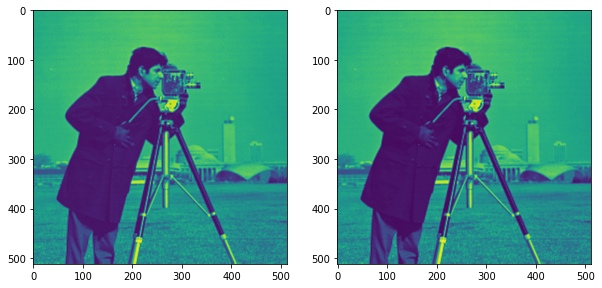

In [198]:
plt.figure(figsize=(10, 20))
plt.subplot(1, 2, 1)
predicted = predicted.reshape(Image.shape)
plt.imshow(predicted)

plt.subplot(1, 2, 2)
Original = RGB_values.reshape(Image.shape)
plt.imshow(Original)

print(f"PSNR : {PSNR(Original, predicted)}")